# Calculating Receiver Position from Android Raw GNSS Measurements

*This notebook was written by [Mitchell Johnson](https://www.johnsonmitchelld.com/). The source code, as well as the gnssutils Python package containing the EphemerisManager module, can be found on [Github](https://github.com/johnsonmitchelld/gnss-analysis).*

Satellite navigation is absolutely fascinating. The GPS receiver in your smartphone uses concepts as diverse as orbital mechanics, digital signal processing, convex optimization, and the theory of relativity to determine your location anywhere on Earth within seconds. From the development of GPS in the 80's until the early 2010s, satellite navigation was a specialized tool, used primarily by the military, airlines, surveyors, and private citizens fortunate enough to own an expensive personal receiver. Widespread GNSS receiver adoption in smartphones over the past decade, combined with the development of new GNSS constellations from China and the EU, have commoditized satellite navigation like never before.

Despite these changes, GNSS receivers were mostly black boxes until recently. Most standalone receivers output only a final position, velocity, and time solution, with dilution of precision and satellite signal-to-noise ratios included if you're lucky.

That changed in 2016 with Google's introduction of the [raw GNSS measurement API](https://developer.android.com/guide/topics/sensors/gnss) in Android 7. Several applications have since been developed to make use of this data, including Google's own [GnssLogger](https://play.google.com/store/apps/details?id=com.google.android.apps.location.gps.gnsslogger&hl=en_US&gl=US), which provides an interface for logging raw GNSS measurements to a text file. It is now possible for any of the billions of Android device owners worldwide to experiment with raw GNSS measurement data for themselves.

What's still missing is an approachable, easy-to-use platform for processing this data. Google's recent paper, Android Raw GNSS Measurement Datasets for Precise Positioning, contains the following table listing publicly available software packages for GNSS positioning:

![title](simple_least_squares_files/gnss_software_table.png)

Notice that all of the open source options are either written in C/C++ or MATLAB. C and C++ are highly performant languages, but neither is particularly approachable without a software engineering background. MATLAB is much more familiar to engineers and scientists, but I believe its widespread use is harmful for reasons I outline [here](https://www.johnsonmitchelld.com/opinion/2020/12/20/stop-teaching-matlab.html).

To address this void in approachable GNSS software packages built on open source platforms, I decided to develop my own. This Jupyter notebook, along with the accompanying EphemerisManager class, provide everything a user needs to calculate the position of their Android phone using recorded GNSS measurements. All that's necessary (in addition to the phone, of course) is an environment capable of running Jupyter notebooks.

I would like to thank the developers of the tools listed above. I used Google's [GPS Measurement Tools](https://github.com/google/gps-measurement-tools) and the European Space Agency's [GNSS resources](https://gage.upc.edu/tutorials/) as references while developing this project, in addition to many other sources mentioned below.

## Data Aquisition

The experiment below was conducted with a sample dataset I collected with Google's GnssLogger app on my Samsung Galaxy S9 Plus while driving through downtown Seattle. If you'd like to collect your own data and process it with this notebook, you can find the code and documentation [here](https://github.com/johnsonmitchelld/gnss-analysis).

The import process and data directory determination below assume that the Python interpreter's working directory is the same as this notebook, and that the gnssutils package and data repository are located in the parent directory. If that is not the case, you'll have to modify accordingly.

In [1]:
import sys, os, csv
parent_directory = os.path.split(os.getcwd())[0]
ephemeris_data_directory = os.path.join(parent_directory, 'data')
sys.path.insert(0, parent_directory)
from datetime import datetime, timezone, timedelta
import pandas as pd
import numpy as np
import navpy
from gnssutils import EphemerisManager

Let's read in a GNSS log file, format the satellite IDs to match up with the RINEX 3.0 standard, and convert the columns we need to calculate receiver position to numeric values. We'll also filter the data so that we're only working with GPS measurements to simplify the rest of the analysis.

In [2]:
# Get path to sample file in data directory, which is located in the parent directory of this notebook
input_filepath = os.path.join(parent_directory, 'data', 'sample', 'gnss_log_2020_12_02_17_19_39.txt')

with open(input_filepath) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row[0][0] == '#':
            if 'Fix' in row[0]:
                android_fixes = [row[1:]]
            elif 'Raw' in row[0]:
                measurements = [row[1:]]
        else:
            if row[0] == 'Fix':
                android_fixes.append(row[1:])
            elif row[0] == 'Raw':
                measurements.append(row[1:])

android_fixes = pd.DataFrame(android_fixes[1:], columns = android_fixes[0])
measurements = pd.DataFrame(measurements[1:], columns = measurements[0])

# Format satellite IDs
measurements.loc[measurements['Svid'].str.len() == 1, 'Svid'] = '0' + measurements['Svid']
measurements.loc[measurements['ConstellationType'] == '1', 'Constellation'] = 'G'
measurements.loc[measurements['ConstellationType'] == '3', 'Constellation'] = 'R'
measurements['SvName'] = measurements['Constellation'] + measurements['Svid']

# Remove all non-GPS measurements
measurements = measurements.loc[measurements['Constellation'] == 'G']

# Convert columns to numeric representation
measurements['Cn0DbHz'] = pd.to_numeric(measurements['Cn0DbHz'])
measurements['TimeNanos'] = pd.to_numeric(measurements['TimeNanos'])
measurements['FullBiasNanos'] = pd.to_numeric(measurements['FullBiasNanos'])
measurements['ReceivedSvTimeNanos']  = pd.to_numeric(measurements['ReceivedSvTimeNanos'])
measurements['PseudorangeRateMetersPerSecond'] = pd.to_numeric(measurements['PseudorangeRateMetersPerSecond'])
measurements['ReceivedSvTimeUncertaintyNanos'] = pd.to_numeric(measurements['ReceivedSvTimeUncertaintyNanos'])

# A few measurement values are not provided by all phones
# We'll check for them and initialize them with zeros if missing
if 'BiasNanos' in measurements.columns:
    measurements['BiasNanos'] = pd.to_numeric(measurements['BiasNanos'])
else:
    measurements['BiasNanos'] = 0
if 'TimeOffsetNanos' in measurements.columns:
    measurements['TimeOffsetNanos'] = pd.to_numeric(measurements['TimeOffsetNanos'])
else:
    measurements['TimeOffsetNanos'] = 0

print(measurements.columns)

Index(['ElapsedRealtimeMillis', 'TimeNanos', 'LeapSecond',
       'TimeUncertaintyNanos', 'FullBiasNanos', 'BiasNanos',
       'BiasUncertaintyNanos', 'DriftNanosPerSecond',
       'DriftUncertaintyNanosPerSecond', 'HardwareClockDiscontinuityCount',
       'Svid', 'TimeOffsetNanos', 'State', 'ReceivedSvTimeNanos',
       'ReceivedSvTimeUncertaintyNanos', 'Cn0DbHz',
       'PseudorangeRateMetersPerSecond',
       'PseudorangeRateUncertaintyMetersPerSecond',
       'AccumulatedDeltaRangeState', 'AccumulatedDeltaRangeMeters',
       'AccumulatedDeltaRangeUncertaintyMeters', 'CarrierFrequencyHz',
       'CarrierCycles', 'CarrierPhase', 'CarrierPhaseUncertainty',
       'MultipathIndicator', 'SnrInDb', 'ConstellationType', 'AgcDb',
       'CarrierFrequencyHz', 'Constellation', 'SvName'],
      dtype='object')


## Pre-processing

Those with experience in GNSS data processing will probably notice that we're missing a few important fields for calculating receiver position. For each satellite the process requires:

* **Time of signal transmission** - in order to calculate the satellite's location when the signal was transmitted
* **Measured pseudorange** - a rough estimate of the distance between each satellite and the receiver before correcting for clock biases, ionospheric delay, and other phenomena which we'll explain later
* **Ephemeris parameters** - a set of parameters required to calculate the satellite's position in space

Of these, the only one provided directly by Android's raw GNSS measurement API is the time of signal transmission, labeled `ReceivedSvTimeNanos`. Fortunately, the European Global Navigation Satellite Systems Agency (GSA) published a very helpful [white paper](https://www.gsa.europa.eu/system/files/reports/gnss_raw_measurement_web_0.pdf) explaining the parameters reported by Android and how they can be used to generate the values we need.

Ephemeris parameters are an exception. The Android API technically has commands for obtaining these, but they don't seem to work on my Galaxy S9 - at least not in the GnssLogger app. Instead we'll get them from the [International GNSS Service](https://igs.org/mgex/data-products/#data) (IGS), which maintains an array of GNSS data products available to the public through NASA's Crustal Dynamics Data Information System, the German Bundesamt für Kartographie und Geodäsie (BKG), and the French Institut Géographique National (IGN). More on this later.

### Timestamp Generation

First things first: what time were these measurements taken?

It turns out this question isn't as simple as it might sound. The GPS system has its own time scale, which differs from UTC by some number of leap seconds. Leap seconds are used to adjust UTC for changes in the rotation of the Earth, and are decided by the International Earth Rotation and Reference Systems Service. If you're interested in reading more about leap seconds and international time standards, you can check out this [FAQ](https://www.nist.gov/pml/time-and-frequency-division/nist-time-frequently-asked-questions-faq) from the US National Institute of Standards and Technology.

We're going to need a Python `datetime` timestamp for each measurement in order to determine which ephemeris files to retrieve from IGS. To get one, let's calculate the GPS time in nanoseconds using the equations from Section 2.4 of the GSA's white paper. Then we'll convert it to a normal Unix timestamp using the `Pandas.to_datetime()` function with the GPS reference epoch.

Note that the UTC flag is set to True in the `Pandas.to_datetime()` method. The timestamp column needs to be in UTC because the ephemeris files provided by IGS are labeled by UTC date and time. Since Python's datetime library defaults to local time on some systems, it was necessary to keep everything timezone-aware to avoid mix-ups.

This nomenclature is a bit confusing since we're using the `to_datetime()` method to create a column called `UnixTime`, not `Utc`. Unix time and UTC are technically in the same time zone, but UTC includes leap seconds, while Unix time does not. Since we're creating a timestamp from the number of seconds elapsed since the GPS epoch, the resulting timestamp could differ from UTC by some number of leap seconds. That's close enough to ensure we get the correct ephemeris file, and it won't affect the actual position calculations because we don't use the `UnixTime` column for those.

Finally, let's split the data into measurement epochs. We do this by creating a new column and setting it to 1 whenever the difference between a timestamp and the previous timestamp is greater than 200 milliseconds using the `DataFrame.shift()` command. Then we use the `Series.cumsum()` method to generate unique numbers for the individual epochs.

In [3]:

measurements['GpsTimeNanos'] = measurements['TimeNanos'] - (measurements['FullBiasNanos'] - measurements['BiasNanos'])
gpsepoch = datetime(1980, 1, 6, 0, 0, 0)
measurements['UnixTime'] = pd.to_datetime(measurements['GpsTimeNanos'], utc = True, origin=gpsepoch)
measurements['UnixTime'] = measurements['UnixTime']

# Split data into measurement epochs
measurements['Epoch'] = 0
measurements.loc[measurements['UnixTime'] - measurements['UnixTime'].shift() > timedelta(milliseconds=200), 'Epoch'] = 1
measurements['Epoch'] = measurements['Epoch'].cumsum()

Next let's calculate the estimated signal transmission and reception times, once again using the equations found in Section 2.4 of the GSA white paper mentioned above. Once we've determined these, we can calculate a measured pseudorange value for each satellite by taking the difference between the two and multiplying by the speed of light:

$$
\rho_{measured} = \frac{(t_{Rx} - t_{Tx})}{1E9} \cdot c
$$


In [4]:
WEEKSEC = 604800
LIGHTSPEED = 2.99792458e8

# This should account for rollovers since it uses a week number specific to each measurement

measurements['tRxGnssNanos'] = measurements['TimeNanos'] + measurements['TimeOffsetNanos'] - (measurements['FullBiasNanos'].iloc[0] + measurements['BiasNanos'].iloc[0])
measurements['GpsWeekNumber'] = np.floor(1e-9 * measurements['tRxGnssNanos'] / WEEKSEC)
measurements['tRxSeconds'] = 1e-9*measurements['tRxGnssNanos'] - WEEKSEC * measurements['GpsWeekNumber']
measurements['tTxSeconds'] = 1e-9*(measurements['ReceivedSvTimeNanos'] + measurements['TimeOffsetNanos'])
# Calculate pseudorange in seconds
measurements['prSeconds'] = measurements['tRxSeconds'] - measurements['tTxSeconds']

# Conver to meters
measurements['PrM'] = LIGHTSPEED * measurements['prSeconds']
measurements['PrSigmaM'] = LIGHTSPEED * 1e-9 * measurements['ReceivedSvTimeUncertaintyNanos']

Now that we have pseudorange values, we can begin the standard process for calculating receiver position. First we need to retrieve the ephemeris data for each satellite from one of the International GNSS Service (IGS) analysis centers. These include NASA's [CDDIS](https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/orbit_products.html) and the German [BKG](https://igs.bkg.bund.de/dataandproducts/index).

This process is, frankly, a pain, so I wrote a Python module to handle the details. You can view the code and documentation [here](https://github.com/johnsonmitchelld/gnss-analysis/tree/main/gnssutils), but all you have to do is initialize an instance of the `EphemerisManager` class with a path to the directory where you want it to cache downloaded files. Then, provide the `get_ephemeris()` method with a Python datetime object and and list of satellites, and it will return a Pandas dataframe of valid ephemeris parameters for the requested satellites.

Broadcast ephemerides are good for four hours from the time they are issued, but the GPS control segment generally uploads new values every two hours. The `EphemerisManager` class downloads a whole day's worth of data at a time and then returns the most recent parameters at the requested time for each satellite. Because of this we're going to run the `get_ephemeris()` method for every epoch in case new parameters were issued since the last measurement was taken.

For the sake of demonstration, let's start by walking through the position solution for just one measurement epoch. We'll use the first epoch in the dataset with measurements from at least five satellites.

In [5]:
manager = EphemerisManager(ephemeris_data_directory)

epoch = 0
num_sats = 0
while num_sats < 5 :
    one_epoch = measurements.loc[(measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)].drop_duplicates(subset='SvName')
    timestamp = one_epoch.iloc[0]['UnixTime'].to_pydatetime(warn=False)
    one_epoch.set_index('SvName', inplace=True)
    num_sats = len(one_epoch.index)
    epoch += 1

sats = one_epoch.index.unique().tolist()
ephemeris = manager.get_ephemeris(timestamp, sats)
print(timestamp)
print(one_epoch[['UnixTime', 'tTxSeconds', 'GpsWeekNumber']])

2020-12-03 01:19:57.432062+00:00
                                  UnixTime     tTxSeconds  GpsWeekNumber
SvName                                                                  
G05    2020-12-03 01:19:57.432062976+00:00  350397.354393         2134.0
G07    2020-12-03 01:19:57.432062976+00:00  350397.362980         2134.0
G08    2020-12-03 01:19:57.432062976+00:00  350397.359065         2134.0
G09    2020-12-03 01:19:57.432062976+00:00  350397.356830         2134.0
G13    2020-12-03 01:19:57.432062976+00:00  350397.353015         2134.0
G14    2020-12-03 01:19:57.432062976+00:00  350397.359692         2134.0
G27    2020-12-03 01:19:57.432062976+00:00  350397.354134         2134.0
G28    2020-12-03 01:19:57.432062976+00:00  350397.358284         2134.0
G30    2020-12-03 01:19:57.432062976+00:00  350397.363215         2134.0


Okay, we've got valid ephemeris parameters and signal transmission time in seconds of the GPS week for one measurement epoch's worth of data. Time to figure out where these satellites are (or where they were at approximately 01:19:57.432 UTC on December 3rd, 2020).

## Coordinate Systems Primer

A brief geometry lesson is in order before I continue. If you ask someone on the street what their location is, they will most likely provide you with some sort of named landmark for reference, e.g. a street name, intersection, or address. Not every location on Earth has a named landmark nearby for reference, so most children learn about the concept of latitude and longitude in school. 

### LLA

Latitude, longitude, and altitude (LLA from here on) together make up a [spherical coordinate system](https://en.wikipedia.org/wiki/Spherical_coordinate_system), which was developed over millennia by geographers for use in celestial navigation. Latitude, longitude and altitude are handy because they quickly give you an idea of where you are generally on Earth - positive latitudes are in the northern hemisphere, positive longitudes west of the Prime Meridian, etc. However, spherical coordinates tend to complicate the math involved with satellite navigation because they are not linear. One degree of latitude equals roughly 69 miles (111 km) at the equator but only 49 miles (79 km) at 45 degrees north or south.

### ECEF

The Earth-centered, Earth-fixed ([ECEF](https://en.wikipedia.org/wiki/ECEF)) coordinate system solves this issue. It is a Cartesian coordinate system with coordinates on X, Y, and Z axes which rotate with the Earth. Satellite navigation systems perform most of their calculations in ECEF coordinates before converting to LLA for user output; hence our function for calculating satellite position will output ECEF coordinates.

### ENU/NED

Another challenge arises when calculating the vector **between** two points on Earth. A linear coordinate system is also desired in this case. However, ECEF doesn't quite work for relative positioning on Earth's surface, because, for example, the X and Y axes can point east, west, up, down, or somewhere in between depending on your location. Hence a third system called [local tangent plane coordinates](https://en.wikipedia.org/wiki/Local_tangent_plane_coordinates) is used to define vectors between coordinates. The most common of these are east, north, up (ENU) and north, east, down (NED), which we will use later.

Calculating satellite position from ephemeris data is a bit involved, but the details are conveniently laid out in Tables 20-III and 20-IV of the GPS [Interface Specification Document](https://www.gps.gov/technical/icwg/IS-GPS-200L.pdf). The function below performs this calculation, taking a Pandas dataframe with the ephemeris parameters for every satellite and a dataseries containing the transmit time for all received signals in seconds since the start of the current GPS week. It also calculates the satellite clock offsets for the given transmission time.

In [6]:
def calculate_satellite_position(ephemeris, transmit_time):
    mu = 3.986005e14
    OmegaDot_e = 7.2921151467e-5
    F = -4.442807633e-10
    sv_position = pd.DataFrame()
    sv_position['sv']= ephemeris.index
    sv_position.set_index('sv', inplace=True)
    sv_position['t_k'] = transmit_time - ephemeris['t_oe']
    A = ephemeris['sqrtA'].pow(2)
    n_0 = np.sqrt(mu / A.pow(3))
    n = n_0 + ephemeris['deltaN']
    M_k = ephemeris['M_0'] + n * sv_position['t_k']
    E_k = M_k
    err = pd.Series(data=[1]*len(sv_position.index))
    i = 0
    while err.abs().min() > 1e-8 and i < 10:
        new_vals = M_k + ephemeris['e']*np.sin(E_k)
        err = new_vals - E_k
        E_k = new_vals
        i += 1
        
    sinE_k = np.sin(E_k)
    cosE_k = np.cos(E_k)
    delT_r = F * ephemeris['e'].pow(ephemeris['sqrtA']) * sinE_k
    delT_oc = transmit_time - ephemeris['t_oc']
    sv_position['delT_sv'] = ephemeris['SVclockBias'] + ephemeris['SVclockDrift'] * delT_oc + ephemeris['SVclockDriftRate'] * delT_oc.pow(2)

    v_k = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*sinE_k,(cosE_k - ephemeris['e']))

    Phi_k = v_k + ephemeris['omega']

    sin2Phi_k = np.sin(2*Phi_k)
    cos2Phi_k = np.cos(2*Phi_k)

    du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
    dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
    di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

    u_k = Phi_k + du_k

    r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k

    i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

    x_k_prime = r_k*np.cos(u_k)
    y_k_prime = r_k*np.sin(u_k)

    Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

    sv_position['x_k'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
    sv_position['y_k'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
    sv_position['z_k'] = y_k_prime*np.sin(i_k)
    return sv_position

# Run the function and check out the results:
sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'])
print(sv_position)

             t_k   delT_sv           x_k           y_k           z_k
sv                                                                  
G05  4797.354393 -0.000027 -2.169285e+07  4.568031e+06  1.461087e+07
G07  4797.362980 -0.000426 -3.714100e+06 -1.642940e+07  2.075276e+07
G08  4797.359065 -0.000002  7.360204e+06 -1.916176e+07  1.671180e+07
G09  4797.356830 -0.000297 -7.513898e+06 -2.535861e+07  2.249150e+06
G13  4797.353015  0.000071 -1.324738e+07  1.036799e+07  2.038926e+07
G14  4797.359692  0.000052 -2.110816e+07 -1.395532e+07  8.071176e+06
G27  4797.354134 -0.000027  1.340518e+07 -7.095042e+06  2.161816e+07
G28  4797.358284  0.000648 -2.237537e+07 -1.338044e+07  5.115684e+06
G30  4797.363215 -0.000346 -1.305779e+07 -9.338017e+06  2.122874e+07


We now have raw pseudorange values, satellite positions, and satellite clock offsets. 

These pseudoranges can be repsresented by the equation ([Misra and Enge, 2006](https://www.gpstextbook.com/)):

$$
\begin{equation}
\rho^{(k)}_{measured} = \sqrt{(x^{(k)} - x_r)^2 + (y^{(k)} - y_r)^2 + (z^{(k)} - z_r)^2} + c \cdot \delta t_r  - c \cdot \delta t^{(k)} + I^{(k)}(t) + T^{(k)}(t) + \epsilon_\rho^{(k)}
\end{equation}
$$

where $x_r$, $y_r$, $z_r$, and $ \delta t_r $  are the receiver position (in ECEF coordinates) and clock bias (in seconds), $x^{(k)}$, $y^{(k)}$, $z^{(k)}$, and $ \delta t^{(k)} $ are the position and clock bias of the $k$th satellite, $c$ is the speed of light, and $I^{(k)}(t)$ and $T^{(k)}(t)$ are the ionospheric and trophospheric delay terms for the $k$th satellite. $\epsilon_\rho^{(k)}$ accounts for all remaining measurement and modeling errors. Following convention in the GNSS community, a superscript is used to identify measurements from a specific satellite, with parenthesis to distinguish between superscripts and exponents.

Since we've calculated the satellite clock offsets, let's go ahead and apply them to generate a corrected pseudorange. We're also going to ignore ionospheric and trophospheric delays, thus lumping them into the error term $\epsilon_\rho^{(k)}$. The expression for the corrected pseudorange then becomes:

$$
\rho^{(k)}_{corrected} = \rho^{(k)} + c \cdot \delta t^{(k)} = \sqrt{(x^{(k)} - x_r)^2 + (y^{(k)} - y_r)^2 + (z^{(k)} - z_r)^2} + c \cdot \delta t_r + \epsilon_\rho^{(k)}
$$


In [7]:
#initial guesses of receiver clock bias and position
b0 = 0
x0 = np.array([0, 0, 0])
xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()

# Apply satellite clock bias to correct the measured pseudorange values
pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
pr = pr.to_numpy()

The following is adapted from ([Blewitt, 1997](http://www.nbmg.unr.edu/staff/pdfs/blewitt%20basics%20of%20gps.pdf)).

Let's drop the subscript for the corrected pseudorange measurements and refer to them simply as $p^{(k)}$. With four or more linearly independent pseudorange measurements, we end up with the system of equations:

$$
\begin{gather*}
\rho^{(1)} = \sqrt{(x^{(1)} - x_r)^2 + (y^{(1)} - y_r)^2 + (z^{(1)} - z_r)^2} + c \cdot \delta t_r + \epsilon_\rho^{(1)} \\
\rho^{(2)} = \sqrt{(x^{(2)} - x_r)^2 + (y^{(2)} - y_r)^2 + (z^{(2)} - z_r)^2} + c \cdot \delta t_r + \epsilon_\rho^{(2)} \\
\rho^{(3)} = \sqrt{(x^{(3)} - x_r)^2 + (y^{(3)} - y_r)^2 + (z^{(3)} - z_r)^2} + c \cdot \delta t_r + \epsilon_\rho^{(3)} \\
\cdots \\
\rho^{(k)} = \sqrt{(x^{(k)} - x_r)^2 + (y^{(k)} - y_r)^2 + (z^{(k)} - z_r)^2} + c \cdot \delta t_r + \epsilon_\rho^{(k)}
\end{gather*}
$$

where $x_r, y_r, z_r$, and $\delta t_r$ are the unkowns. We will substitute the receiver clock bias term with an equivalent value in meters:

$$
b = c \cdot \delta t_r
$$

Since the system is nonlinear, we must approximate the solution using the [Gauss-Newton algorithm](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) for solving [non-linear least squares](https://en.wikipedia.org/wiki/Non-linear_least_squares) problems. Let us define a function, $P$, for calculating an estimated or modeled pseudorange $\hat{\rho}^{(k)}$ based on estimates $\hat{x}, \hat{y}, \hat{z}, \hat{b}$ of the real position and clock offset values $x, y, z, b$:

$$
\hat{\rho}^{(k)} = P(\hat{x}, \hat{y}, \hat{z}, \hat{b}, k) = \sqrt{(x^{(k)}\ - \hat{x})^2 + (y^{(k)} - \hat{y})^2 + (z^{(k)} - \hat{z})} + \hat{b}
$$

We perform a first-order Taylor series expansion about our estimated values:

$$
P(x, y, z, b, k) = P(\hat{x}, \hat{y}, \hat{z}, \hat{b}, k) + P'(\hat{x}, \hat{y}, \hat{z}, \hat{b}, k)(x - \hat{x}, y - \hat{y}, z - \hat{z}, b - \hat{b})
$$

where $P(x, y, z, b, k)$ is equal to our measured or observed psedurange $\rho^{(k)}$. The difference between the observed and computed pseudorange is therefore:

$$
\Delta \rho = P(x, y, z, b, k) - P(\hat{x}, \hat{y}, \hat{z}, \hat{b}, k) = P'(\hat{x}, \hat{y}, \hat{z}, \hat{b}, k)(x - \hat{x}, y - \hat{y}, z - \hat{z}, b - \hat{b})
$$

Converting to matrix form and adding the error term $\epsilon$, we have:

$$
\Delta \rho= \begin{pmatrix} \frac{\delta \rho}{\delta x} & \frac{\delta \rho}{\delta y} &
\frac{\delta \rho}{\delta z} & \frac{\delta \rho}{\delta b} \end{pmatrix} 
\begin{pmatrix} \Delta x \\ \Delta y \\ \Delta z \\ \Delta b \end{pmatrix} + \epsilon
$$

Thus for $k$ satellites, we now have the system of $k$ linear equations:

$$
\begin{pmatrix} \Delta \rho^{(1)} \\
\Delta \rho^{(2)} \\
\Delta \rho^{(3)} \\
\vdots \\
\Delta \rho^{(k)}
\end{pmatrix}
=
\begin{pmatrix} \frac{\delta P^{(1)}}{\delta x} & \frac{\delta P^{(1)}}{\delta y} &
\frac{\delta \rho^{(1)}}{\delta z} & \frac{\delta \rho^{(1)}}{\delta b} \\
\frac{\delta \rho^{(2)}}{\delta x} & \frac{\delta \rho^{(2)}}{\delta y} &
\frac{\delta \rho^{(2)}}{\delta z} & \frac{\delta \rho^{(2)}}{\delta b} \\
\frac{\delta \rho^{(3)}}{\delta x} & \frac{\delta \rho^{(3)}}{\delta y} &
\frac{\delta \rho^{(3)}}{\delta z} & \frac{\delta \rho^{(3)}}{\delta b} \\
\vdots & \vdots & \vdots & \vdots \\
\frac{\delta \rho^{(k)}}{\delta x} & \frac{\delta \rho^{(k)}}{\delta y} &
\frac{\delta \rho^{(k)}}{\delta z} & \frac{\delta \rho^{(k)}}{\delta b} 
\end{pmatrix} 
\begin{pmatrix} \Delta x \\ \Delta y \\ \Delta z \\ \Delta b \end{pmatrix} + 
\begin{pmatrix}
\epsilon^{(1)} \\
\epsilon^{(2)} \\
\epsilon^{(3)} \\
\vdots \\
\epsilon^{(k)} \\
\end{pmatrix}
$$

In matrix notation, this equation is commonly written

$$
\mathbf{b} = \mathbf{Ax} + \mathbf{\epsilon}
$$

where vectors are denoted with boldface lower case characters and matrices with boldface upper case. GNSS resources typically refer to the matrix $\mathbf{A}$ as the geometry matrix $\mathbf{G}$. We will follow this convention here. We will call the pseudorange residual matrix $\Delta \mathbf{\rho}$. It also improves clarity to separate the receiver position from the clock offset, so we will continue to denote the clock offset $b$ while writing the position $\Delta x, \Delta y, \Delta z$ in vector form $\Delta \mathbf{x}$. Thus our system of linear equations becomes,

$$
\Delta \mathbf{\rho} = \mathbf{G} \begin{pmatrix} \Delta \mathbf{x} \\ \Delta b \end{pmatrix} + \mathbf{\epsilon}
$$

It turns out the first three columns of $\mathbf{G}$ are just the unit vectors between the $k$th satellite and the estimated receiver position. This is because the unit vector effectively represents the proportion of the pseudorange which is tangent to each dimension. These unit vectors are found by normalizing the vectors $\mathbf{x}^{(k)} - \mathbf{\hat{x}}$ by their magnitudes $r^{(k)}$, where

$$
r^{(k)} = \lVert \mathbf{x}^{(k)} - \mathbf{\hat{x}} \rVert = \sqrt{(x^{(k)} - \hat{x})^2 + (y^{(k)} - \hat{y})^2 + (z^{(k)} - \hat{z})^2}
$$

All values in the fourth column equal 1, because the clock offset adds directly to the pseudorange with no geometric scaling factor required. Thus the geometry matrix G becomes:

$$
\mathbf{G} = 
\begin{pmatrix}
\frac{x^{(1)} - \hat{x}}{r^{(1)}} & \frac{y^{(1)} - \hat{y}}{r^{(1)}} &
\frac{z^{(1)} - \hat{z}}{r^{(1)}} & 1 \\
\frac{x^{(2)} - \hat{x}}{r^{(2)}} & \frac{y^{(2)} - \hat{y}}{r^{(2)}} &
\frac{z^{(2)} - \hat{z}}{r^{(2)}} & 1 \\
\frac{x^{(3)} - \hat{x}}{r^{(3)}} & \frac{y^{(3)} - \hat{y}}{r^{(3)}} &
\frac{z^{(3)} - \hat{z}}{r^{(3)}} & 1 \\
\vdots & \vdots & \vdots & \vdots \\
\frac{x^{(k)} - \hat{x}}{r^{(k)}} & \frac{y^{(k)} - \hat{y}}{r^{(k)}} &
\frac{z^{(k)} - \hat{z}}{r^{(k)}} & 1 \\
\end{pmatrix} 
$$


For a full derivation of these partial derivatives, refer to Misra and Enge, [Raquet (2013)](http://indico.ictp.it/event/a12180/session/21/contribution/12/material/0/0.pdf), or Ankur Mohan's excellent [blog post](https://www.telesens.co/2017/07/17/calculating-position-from-raw-gps-data/).

The matrix $\Delta \mathbf{\rho}$ is the difference between the measured and calculated pseudorange with the estimated parameters, calculated as follows:

$$
\Delta \mathbf{\rho} = 
\begin{pmatrix} \Delta P^{(1)} \\
\Delta P^{(2)} \\
\Delta P^{(3)} \\
\vdots \\
\Delta P^{(k)}
\end{pmatrix}
=
\begin{pmatrix}
\rho^{(1)} - \hat{\rho}^{(1)} \\
\rho^{(2)} - \hat{\rho}^{(2)}  \\
\rho^{(3)} - \hat{\rho}^{(3)}  \\
\vdots \\
\rho^{(k)} -  \hat{\rho}^{(k)}  \\
\end{pmatrix}
=
\begin{pmatrix}
\rho^{(1)} - r^{(1)} - b \\
\rho^{(2)} - r^{(2)} - b \\
\rho^{(3)} - r^{(3)} - b \\
\vdots \\
\rho^{(k)} - r^{(k)} - b  \\
\end{pmatrix}
$$

Solving the linear system to minimise the sum of the squared residuals $\epsilon^{(k)}$ results in the solution to the normal equations, 

$$
\begin{pmatrix} \Delta x \\ \Delta y \\ \Delta z \\ \Delta b \end{pmatrix}
=
\begin{pmatrix} \Delta \mathbf{x} \\ \Delta b \end{pmatrix}
=
\begin{pmatrix}
\mathbf{G}^T \mathbf{G}
\end{pmatrix}^{-1} \mathbf{G}^T \Delta \mathbf{\rho}
$$

See p. 17 of [Blewitt](http://www.nbmg.unr.edu/staff/pdfs/blewitt%20basics%20of%20gps.pdf) (1997) for a full derivation of this solution. After performing each linear least squares update, the estimated parameters $\mathbf{\hat{x}}, \mathbf{b}$ are updated:

$$
\begin{pmatrix}
\hat{x}_{i + 1} \\
\hat{y}_{i + 1} \\
\hat{z}_{i + 1} \\
\hat{b}_{i + 1} \\
\end{pmatrix}
=
\begin{pmatrix}
\hat{x}_{i} \\
\hat{y}_{i} \\
\hat{z}_{i} \\
\hat{b}_{i} \\
\end{pmatrix}
+
\begin{pmatrix} \Delta x \\ \Delta y \\ \Delta z \\ \Delta b \end{pmatrix}
$$

This process is performed iteratively until the magnitude of the change in position, $\lVert \Delta \mathbf{x} \rVert$, falls below a set threshold. In practice it usually only takes a few iterations for the solution to converge.

Below is the function to calculate rough receiver position. Its inputs are Numpy arrays containing satellite positions in the ECEF frame, pseudorange measurements in meters, and initial estimates of receiver position and clock bias. The unit for clock bias is meters, so you need to divide by the speed of light to convert to seconds.

This function is adapted and simplified from the MATLAB code in Ankur Mohan's [blog](https://www.telesens.co/2017/07/17/calculating-position-from-raw-gps-data/). It's a simple least squares iteration with no correction for ionospheric delay or satellite movement during signal time of flight.

In [8]:
def least_squares(xs, measured_pseudorange, x0, b0):
    dx = 100*np.ones(3)
    b = b0
    # set up the G matrix with the right dimensions. We will later replace the first 3 columns
    # note that b here is the clock bias in meters equivalent, so the actual clock bias is b/LIGHTSPEED
    G = np.ones((measured_pseudorange.size, 4))
    iterations = 0
    while np.linalg.norm(dx) > 1e-3:
        r = np.linalg.norm(xs - x0, axis=1)
        phat = r + b0
        deltaP = measured_pseudorange - phat
        G[:, 0:3] = -(xs - x0) / r[:, None]
        sol = np.linalg.inv(np.transpose(G) @ G) @ np.transpose(G) @ deltaP
        dx = sol[0:3]
        db = sol[3]
        x0 = x0 + dx
        b0 = b0 + db
    norm_dp = np.linalg.norm(deltaP)
    return x0, b0, norm_dp

x, b, dp = least_squares(xs, pr, x0, b0)
print(navpy.ecef2lla(x))
print(b/LIGHTSPEED)
print(dp)

(47.58626777321704, -122.32842161909167, -4.783203065395355)
2.214374492481878e-07
29.948493973072832


Looks like it worked! The pseudorange residual is in the tens of meters, which is reasonable considering we didn't correct for ionospheric delay or the rotation of the Earth during signal transmission.

Now let's wrap this entire process into a loop to calculate receiver position for every measurement epoch in the dataset with more than 4 satellite measurements.



In [9]:
ecef_list = []
for epoch in measurements['Epoch'].unique():
    one_epoch = measurements.loc[(measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)] 
    one_epoch = one_epoch.drop_duplicates(subset='SvName').set_index('SvName')
    if len(one_epoch.index) > 4:
        timestamp = one_epoch.iloc[0]['UnixTime'].to_pydatetime(warn=False)
        sats = one_epoch.index.unique().tolist()
        ephemeris = manager.get_ephemeris(timestamp, sats)
        sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'])

        xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()
        pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
        pr = pr.to_numpy()

        x, b, dp = least_squares(xs, pr, x, b)
        ecef_list.append(x)
    
ecef_array = np.stack(ecef_list, axis=0)
lla_array = np.stack(navpy.ecef2lla(ecef_array), axis=1)
ref_lla = lla_array[0, :]
ned_array = navpy.ecef2ned(ecef_array, ref_lla[0], ref_lla[1], ref_lla[2])


Finally, we'll convert the list of NED translations into a Pandas dataframe and create a plot of change in position relative to the first measurement epoch.

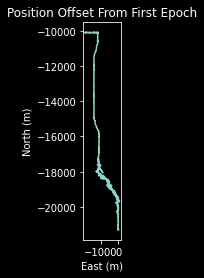

In [10]:
import matplotlib.pyplot as plt
ned_df = pd.DataFrame(ned_array, columns=['N', 'E', 'D'])
plt.style.use('dark_background')
plt.plot(ned_df['E'], ned_df['N'])

# Add titles
plt.title('Position Offset From First Epoch')
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.gca().set_aspect('equal', adjustable='box')